In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pytorch-transformers

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 
if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))

Using Tesla K80 GPUs


# Test

In [ ]:
save_path = '/content/drive/MyDrive'
df_test = pd.read_csv(save_path + '/test.csv')

# Facts

In [ ]:
df = pd.read_csv(save_path + '/facts2.csv')

In [ ]:
df_new = df

# full_marked_dataset

In [ ]:
df = pd.read_csv(save_path + '/full_marked_dataset.csv')
df = df.drop('Unnamed: 0', 1)
df = df.rename(columns={'text': 'texts', 'ans': 'labels'})
df.labels = df.labels.replace('животные', 0).replace('музыка', 1).replace('спорт', 2).replace('литература', 3).replace('неизвестно', 4)
df = df.drop([i for i in range(len(df.labels)) if df.labels[i] == 4], 0)
df = df.reset_index(drop=True)

# Facts & full_marked_dataset

In [ ]:
for i in range(len(df_new)):
  df.loc[-i-1] = df_new.loc[i]
df = df.reset_index(drop=True)

# NN

In [ ]:
categories = ("животные", "музыка", "спорт", "литература")
catToCatTest = {'животные':3, 'музыка':1, 'спорт':0, 'литература':2}

In [ ]:
sentMaxLen = 50
max_len_tokenized = 200
max_test = 200

In [ ]:
import string
 
alphabet = set('абвгдеёжзийклмнопрстуфхцчшщъыьэюя ')

def generateTexts(texts, windowLen, only_long=True):
  out = []
  for text in texts:
    text = text.lower().replace('\n', ' ')
    text = ''.join(c for c in text if c in alphabet)
    text = text.split()
    if only_long:
      out.extend([' '.join(text[x:x+windowLen]) for x in range(0, len(text)-windowLen, windowLen)])
    else:
      out.extend([' '.join(text[x:x+windowLen]) for x in range(0, len(text), windowLen)])
  return out

In [ ]:
sentences = []
labels = []
 
for i in range(len(df.texts)):
  cat_texts = generateTexts([df.texts[i]], sentMaxLen, only_long=False)
  label = df.labels[i]
  for j in cat_texts:
    sentences.append(j)
    labels.append(label)
 
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
X_train = np.array(sentences)
Y_train = np.array(labels)

In [ ]:
from pytorch_transformers import BertTokenizer, BertConfig
 
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-uncased", do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in X_train]
tokenized_texts = pad_sequences(
  tokenized_texts,
  maxlen=max_len_tokenized,
  dtype=object,
  truncating="post",
  padding="post",
  value='[PAD]'
)
attention_masks = [[1 if i != '[PAD]' else 0 for i in seq] for seq in tokenized_texts]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [ ]:
train_inputs = torch.tensor(input_ids)
train_labels = torch.tensor(Y_train)
train_masks = torch.tensor(attention_masks)

In [ ]:
cnt_steps_batch = 2
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
  train_data,
  sampler=RandomSampler(train_data),
  batch_size=20
)

In [ ]:
from pytorch_transformers import AdamW, BertForSequenceClassification

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-uncased", num_labels=4, output_hidden_states=True, output_attentions=True)
model.load_state_dict(torch.load(save_path + '/model.pth'))
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
  {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.01},
  {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

In [ ]:
def prediction(sentence, max_key_words=1):
  sentence = sentence.lower().replace('\n', ' ').replace('ё', 'е').replace('й', 'и')
  sentence = ''.join(c for c in sentence if c in alphabet)
  sentence = ' '.join(sentence.split()[:max_test])
  sentence = '[CLS] ' + sentence + ' [SEP]'
  words = sentence.split()
  tokenized = tokenizer.tokenize(sentence)

  now_word = 0
  now_ind = 0
  token_to_word = []
  for i in tokenized:
    token_to_word.append(now_word)
    for j in range(len(i)):
      if i[j] != words[now_word][now_ind]:
        continue
      now_ind += 1
      if now_ind == len(words[now_word]):
        now_ind = 0
        now_word += 1
  
  ids = [tokenizer.convert_tokens_to_ids(tokenized)]
  ids = torch.tensor(ids)
  ids = ids.to(device)
  label = torch.tensor([0]).to(device)
  with torch.no_grad():
    logits = model(ids, token_type_ids=None, attention_mask=None, labels=label)
  
  ans = logits[1].detach().to('cpu').numpy()
  ans_ind = np.argmax(ans, axis=1).item()
  ans_cat = categories[ans_ind]

  attention = logits[3][11][0][11][0].detach().to('cpu').numpy()
  max_inds = np.flip(np.argsort(attention))
  all_key_words = ['[SEP]', '[CLS]']
  for i in max_inds:
    if words[token_to_word[i]] in all_key_words:
      continue
    all_key_words.append(words[token_to_word[i]])
    if len(all_key_words)-2 == max_key_words:
      break
  return ans_cat, all_key_words[2:]

In [ ]:
from IPython.display import clear_output
 
def model_train(epochs=1):
  test_acc = []
  test_f1 = []
  for ep in range(epochs):
    train_loss_set = []
    
    model.train()
    
    for step, batch in enumerate(train_dataloader):
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch
      
      loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      
      train_loss_set.append(loss[0].item())  
      
      loss_back = loss[0] / cnt_steps_batch

      loss_back.backward()
      
      if (step+1)%cnt_steps_batch == 0:
        optimizer.step()
        optimizer.zero_grad()
      
      clear_output(True)
      plt.plot(train_loss_set)
      plt.title(f"Training loss on epoch {ep+1}/{epochs}")
      plt.xlabel("Batch")
      plt.ylabel("Loss")
      plt.show()
      plt.plot(test_acc)
      plt.title("Accuracy")
      plt.xlabel("Epoch")
      plt.ylabel("Accuracy")
      plt.show()
      plt.plot(test_f1)
      plt.title("F1")
      plt.xlabel("Epoch")
      plt.ylabel("F1")
      plt.show()

    model.eval()

    test_labels = df_test.ans
    test_preds = []

    for text in df_test.task:
      ans_cat, _ = prediction(text)
      test_preds.append(catToCatTest[ans_cat])

    test_acc.append(accuracy_score(test_labels, test_preds))
    test_f1.append(f1_score(test_labels, test_preds, average='macro'))

    torch.save(model.state_dict(), save_path + f'/model_{ep}.pth')

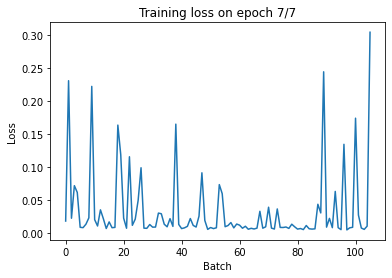

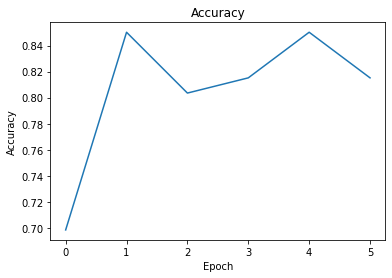

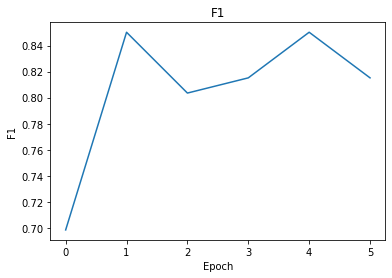

In [ ]:
model_train(7)

In [ ]:
torch.save(model.state_dict(), save_path + '/model.pth')

# Test

In [ ]:
model.eval()

test_labels = df_test.ans
test_preds = []

for text in df_test.task:
  ans_cat, _ = prediction(text)
  test_preds.append(catToCatTest[ans_cat])

print(f"Accuracy: {accuracy_score(test_labels, test_preds)}")
print(f"F1: {f1_score(test_labels, test_preds, average='macro')}")

Accuracy: 0.8521400778210116
F1: 0.8247984565417513


In [ ]:
ans_cat, all_key_words = prediction('1.29. Вороны высиживают яйца три недели. Сколько дней высиживают яйца вороны?', 3)
print(ans_cat)
print(all_key_words)

животные
['вороны', 'яица', 'высиживают']


In [ ]:
ans_csv = []
for i, text in enumerate(df_test.task):
  ans_cat, all_key_words = prediction(text, 3)
  ans_csv.append([i, ans_cat, '; '.join(all_key_words)])

ans_df = pd.DataFrame(ans_csv, columns=['id', 'category', 'keywords'])

In [ ]:
ans_df.head(20)

,id,category,keywords
0,0,спорт,у; хоккею; сеичас
1,1,животные,собак; коробки; корма
2,2,спорт,выбора; учащимся; навравления
3,3,литература,вопросы; вопрос; задачи
4,4,литература,тетради; множество; изобразите
5,5,спорт,при; он; дима
6,6,литература,книг; сотыхвычисли; сотых
7,7,спорт,причем; гребца; но
8,8,спорт,машина; наиди; ехала
9,9,спорт,раздевалки; спортзала; гребцов


In [ ]:
ans_df.to_csv(save_path + '/ans_6.csv', index=False)